# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
-Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
-Контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


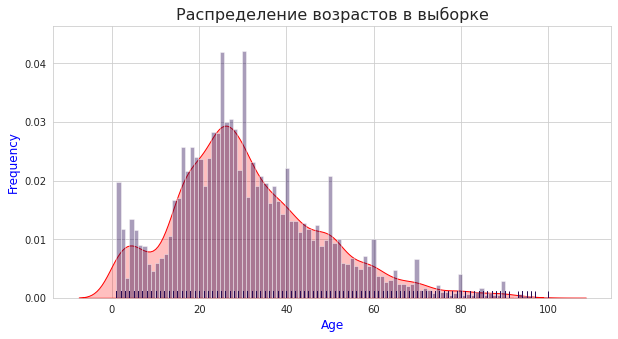

In [4]:
plt.figure(figsize=(10, 5))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], 
             rug=True,bins=100, 
             kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Распределение возрастов в выборке', fontsize=16)
plt.show()

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


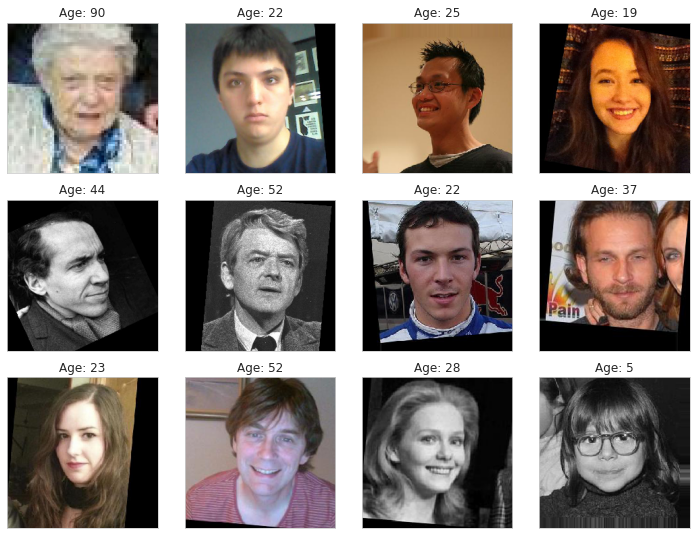

In [23]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод по исследовательскому анализу**

Исходный датасет имеет небольшой объем информации, состоит из 7591 размеченных по возрасту фотографий.  
Представлены клиенты всех возрастов.  
Средний возраст клиента 31год Больше всего клиентов в диапазоне от 20 до 41 года.  
Изображения имеют размер 256х256х3  
Фотографии содержат дополнительные артефакты которые могут усложнить обучение модели

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```

Train for 356 steps, validate for 119 steps
Epoch 1/12
356/356 - 52s - loss: 220.2982 - mae: 10.7109 - val_loss: 337.3768 - val_mae: 13.6343
Epoch 2/12
356/356 - 42s - loss: 84.9461 - mae: 6.9613 - val_loss: 190.0241 - val_mae: 10.1227
Epoch 3/12
356/356 - 43s - loss: 56.0679 - mae: 5.7321 - val_loss: 114.3353 - val_mae: 8.1287
Epoch 4/12
356/356 - 42s - loss: 42.6817 - mae: 5.0298 - val_loss: 78.2394 - val_mae: 6.6318
Epoch 5/12
356/356 - 43s - loss: 35.6636 - mae: 4.5139 - val_loss: 77.1864 - val_mae: 6.6137
Epoch 6/12
356/356 - 43s - loss: 27.6574 - mae: 4.0496 - val_loss: 82.8197 - val_mae: 7.1547
Epoch 7/12
356/356 - 43s - loss: 22.2236 - mae: 3.5931 - val_loss: 99.4033 - val_mae: 7.8166
Epoch 8/12
356/356 - 42s - loss: 18.0750 - mae: 3.2530 - val_loss: 65.3081 - val_mae: 6.1186
Epoch 9/12
356/356 - 43s - loss: 13.4991 - mae: 2.8062 - val_loss: 63.3785 - val_mae: 6.0227
Epoch 10/12
356/356 - 49s - loss: 11.8312 - mae: 2.6146 - val_loss: 64.4520 - val_mae: 6.0813
Epoch 11/12
356/356 - 59s - loss: 11.9827 - mae: 2.6329 - val_loss: 68.5505 - val_mae: 6.1582
Epoch 12/12
356/356 - 59s - loss: 11.3021 - mae: 2.5659 - val_loss: 63.0641 - val_mae: 6.0450

119/119 - 12s - loss: 63.0641 - mae: 6.0450
Test MAE: 6.0450

```

## Анализ обученной модели

В данном проекте использована архитектура ResNet50.
При обучении модели удалось добиться снижения MAE до 6, путем уменьшения learning  rate до 0.0001 и увеличения эпох до 12. 
Погрешность в возрасте на 6 лет допустима в данной сфере бизнеса, так как возрастные категории покупателей  
Использование GPU позволило значительно ускорить процесс обучения.